# EVs - modeling 

goal: model the impact of EVs on the grid

In [1]:
## Necessaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

## Metadata on EVs and their usage

Ideas:
- could show the variation of EVs over Switzerland (for different cantons) and over time
- be able to play with the constraints => different scenarios 

## Estimate the evolution of numbers EVs in Switzerland and the technology

In [55]:
data = pd.read_csv('data/ev_data.csv', encoding='ISO-8859-1')
data["Canton"].unique()


array(['Switzerland', 'Zürich', 'Bern', 'Luzern', 'Uri', 'Schwyz',
       'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 'Solothurn',
       'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen',
       'Appenzell-Ausserrhoden', 'Appenzell-Innerrhoden', 'Sankt Gallen',
       'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 'Valais',
       'Neuchâtel', 'Genève', 'Jura', 'Confederation'], dtype=object)

In [3]:
data.head()

,Canton,Vehicle group / type,Fuel,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Switzerland,> Passenger cars,Petrol,2905762,2975154,3006666,3022762,3073062,3132238,3166299,...,3234560,3201710,3173806,3149902,3127023,3114726,3099442,3087390,3054773,2991092
1,Switzerland,> Passenger cars,Diesel,79129,81883,83640,85703,90747,95585,100412,...,1035843,1123676,1214075,1291500,1346938,1374246,1382645,1379077,1360111,1319337
2,Switzerland,> Passenger cars,Electricity,409,671,771,774,775,770,759,...,2683,4439,7531,10724,14539,19181,28716,43396,71697,110751
3,Switzerland,> Passenger cars,Other,97,90,151,284,458,583,623,...,47799,54665,62657,71903,82323,94535,113149,148472,222785,300100
4,Switzerland,> Passenger cars,Without motor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def process_data(df:  pd.core.frame.DataFrame)  -> pd.DataFrame:
    ## Function to keep useful information from the data 
    df = df[(df["Canton"] == "Switzerland") & (df["Vehicle group / type"] == "> Passenger cars")].drop(columns=['Canton', 'Vehicle group / type'])
    df.set_index('Fuel', inplace=True)
    df = df.T
    df.drop(columns=["Without motor"], inplace=True)
    df.rename(columns={'Other': 'hybrid', 'Electricity': 'battery_electric'}, inplace=True)
    df["total_car"] = df.sum(axis=1)
    df['Year'] = df.index
    df = df.reset_index(drop=True)
    return df


In [8]:
def plot_evolution(df: pd.core.frame.DataFrame) -> None:
    plt.figure(figsize=(15, 8))
    
    sns.lineplot(data=df, x='Year', y='Petrol', label='Petrol')
    sns.lineplot(data=df, x='Year', y='Diesel', label='Diesel')
    sns.lineplot(data=df, x='Year', y='hybrid', label='Hybrid')
    sns.lineplot(data=df, x='Year', y='battery_electric', label='Battery electric')
    sns.lineplot(data=df, x='Year', y='total_car', label='Total')
    
    # Set the x-ticks and labels for every 2 years
    x_ticks = df['Year'].unique()[::2]
    x_tick_labels = [str(year) for year in x_ticks]
    
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    

    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Number of cars')
    plt.title('Evolution of the number of cars in Switzerland over years')
    plt.show()

In [52]:
class forecast_number_car():
    def __init__(self, df : pd.DataFrame, year_constraint, petrol_constraint, diesel_constraint, hybrid_constraint, battery_elecrtic_constraint, pol_degree, weights = "exp") -> None:
        self.df = df
        self.year_constraint = year_constraint
        self.end_year = self.df["Year"].astype(int).max()
        self.petrol_constraint = petrol_constraint
        self.diesel_constraint = diesel_constraint
        self.hybrid_constraint = hybrid_constraint
        self.battery_elecrtic_constraint = battery_elecrtic_constraint
        self.pol_degree = pol_degree
        self.weights = weights
        self.__df_constraint()
        self.__polynomial_regression()
        self.__concat_df()

    def __df_constraint(self) -> pd.DataFrame:
        total_car_constraint = self.petrol_constraint + self.diesel_constraint + self.hybrid_constraint + self.battery_elecrtic_constraint
        intercept_value = pd.DataFrame({"Year": self.year_constraint, "Petrol": self.petrol_constraint, "Diesel": self.diesel_constraint, "hybrid": self.hybrid_constraint, "battery_electric": self.battery_elecrtic_constraint, "total_car": total_car_constraint}, index=[0])
        self.df = pd.concat([self.df, intercept_value], ignore_index=True)

    def __polynomial_regression(self) -> pd.DataFrame:

        if self.weights == "exp":
            weights = np.exp(np.linspace(-10, 0, len(self.df)))
        else:
            weights = np.linspace(0, 1, len(self.df))

        self.data_ev_forecast = pd.DataFrame({'Year': list(range(self.end_year, self.year_constraint))})

        # Create a loop to perform polynomial regression for each column
        for col in self.df.columns:
            if col == 'Year':
                continue  # Skip the 'Year' column
    
            # Create polynomial features
            poly = PolynomialFeatures(degree=self.pol_degree)
            X_poly = poly.fit_transform(self.df[['Year']])
    
            # Create a linear regression model
            model = LinearRegression()
    
            # Fit the model to the polynomial features for the current column
            model.fit(X_poly, self.df[col], sample_weight=weights)
    
            # Forecast future values for each year from 2024 to 2050
            years_forecast = list(range(self.end_year, self.year_constraint))
            future_years_poly = poly.transform(np.array(years_forecast).reshape(-1, 1))
            predictions = model.predict(future_years_poly)
    
            # Create a new column with the predicted values and add it to the DataFrame
            self.data_ev_forecast[col] = predictions

    def __concat_df(self) -> pd.DataFrame:
        self.df = pd.concat([self.df, self.data_ev_forecast], ignore_index=True)
        self.df = self.df.astype({'Year': str})
        self.df = self.df.sort_values(by=['Year'])

    def get_df(self) -> pd.DataFrame:
        return self.df
    

In [56]:
data_ev = process_data(data)
data_ev.head()

Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
0,2905762,79129,409,97,2985397,1990
1,2975154,81883,671,90,3057798,1991
2,3006666,83640,771,151,3091228,1992
3,3022762,85703,774,284,3109523,1993
4,3073062,90747,775,458,3165042,1994


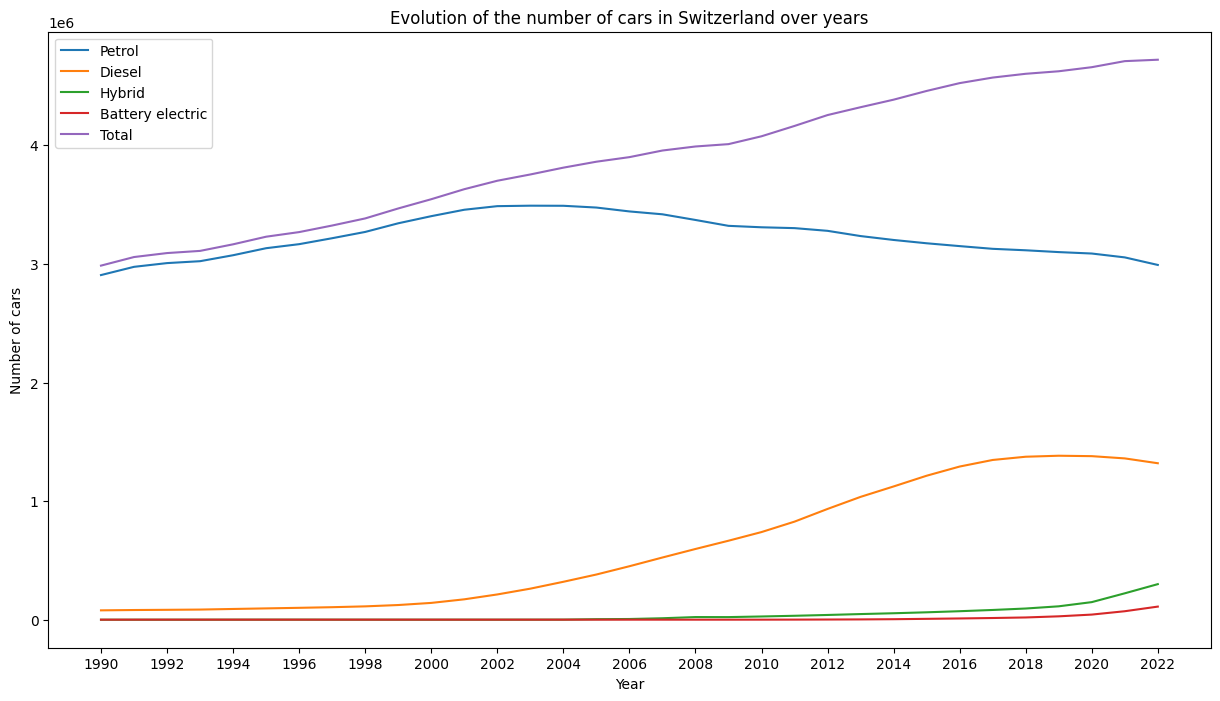

In [57]:
# Plot the evolution of the number of cars in Switzerland over years from historical data

plot_evolution(data_ev)

In [59]:
# Forecasting the number of cars in Switzerland with a plynomial regression model up to 2050

data_ev_forecast = forecast_number_car(data_ev, year_constraint=2050, petrol_constraint=10000, diesel_constraint=0 , hybrid_constraint = 1e6, battery_elecrtic_constraint=5e6, pol_degree=3, weights = "exp").get_df()
data_ev_forecast.tail()

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warni

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
58,754353.650513,330682.414124,3.638102e+06,1.020665e+06,5.743852e+06,2046
59,580752.102295,250535.464661,3.952155e+06,1.022319e+06,5.805813e+06,2047
60,398975.319580,168524.371460,4.283508e+06,1.019628e+06,5.870690e+06,2048
61,208818.421265,84774.525574,4.632617e+06,1.012366e+06,5.938633e+06,2049
33,10000.000000,0.000000,5.000000e+06,1.000000e+06,6.010000e+06,2050


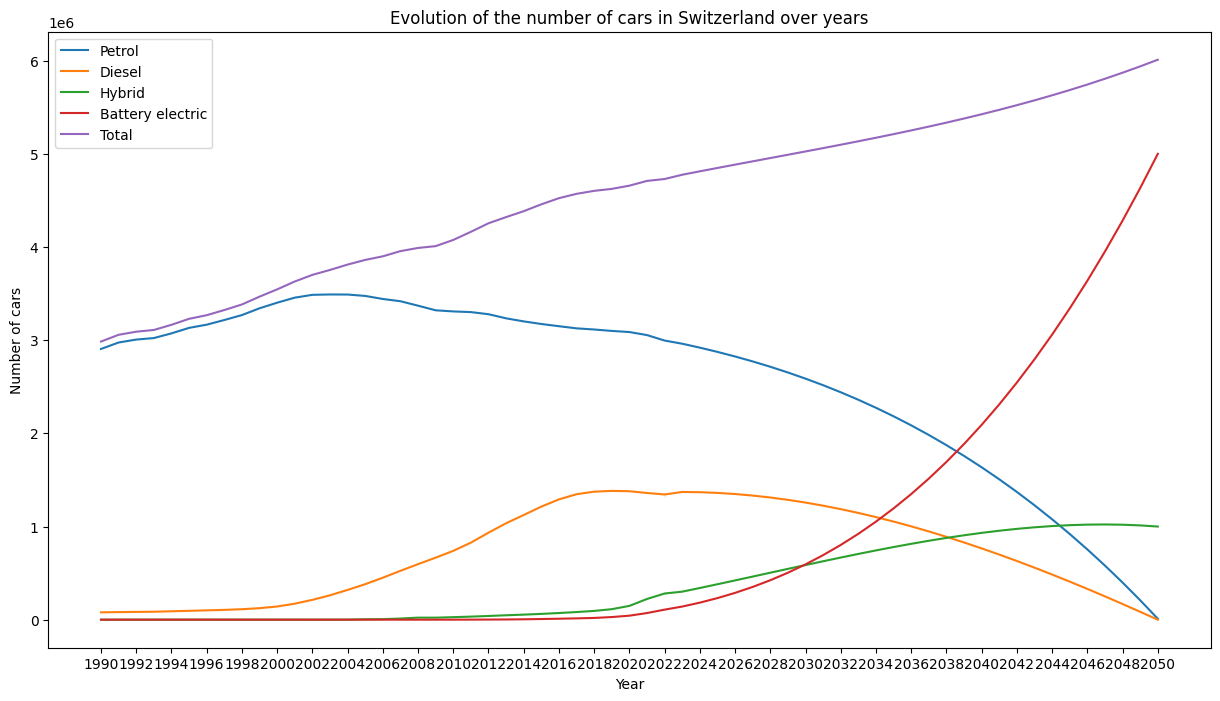

In [60]:
plot_evolution(data_ev_forecast)

## Model the distibution of charging start time over a day 

## Model the constraints of user and from charging 

## Model the overall load of EVs on the grid 

## Model the potential for flexibility

## Visualize the flexibility over time and for different scenarios